In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel('proposals_preprocess_0812_nlp.xlsx')

### Result: Positive or Negative

#### choice_win
- 1: Positive answer is winner
- -1: Negative
- 0: Neutral or Abstain
- -2: Not related to sentiment. Just choice
#### Limitation
- Just choice [No agreement]
  - OIP-149: Backing Ratification for Cooler Loans and RBS
    - [-1, -1, -1]
    - `['Option A: dash only', 'Option B: include Redacted swap', 'Reject OIP-149']`
- Hard to say which one is "agreement" 
  - [AIP-72-B] Addition of FRAX as alUSD collateral 
    - [-1, -1, -1, -1]
    - `['No FRAX collateral for alUSD', 'Conservative  (2M FRAX)', 'Moderate (6M FRAX)', 'Aggressive (10M FRAX)']`
  - [ARFC] Onboarding ETHx to Aave V3 Ethereum Market	
    - [-1, -1, -1]
    - `['Aggressive Option', 'Conservative Option', 'NAY']`



In [3]:
!pip install --user --upgrade -q transformers


[notice] A new release of pip available: 22.3 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from transformers import pipeline
from ast import literal_eval
import string
import re

from collections import Counter


argmax = lambda lst: lst.index(max(lst)) if lst else -1
emoji = r"[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\u2600-\u26FF\u2700-\u27BF\U0001F900-\U0001F9FF]"
valid_str = lambda x: ''.join(re.findall(f'[a-zA-Z ]|{emoji}+', x)).strip().lower()
valid_csv_str = lambda x: ''.join(re.findall(
    f"[a-zA-Z \[\]\'\"\,]|{emoji}+", x.replace("\\'","").replace('\\"',"")
)).strip().lower()

classifier = pipeline('sentiment-analysis',
    model='distilbert/distilbert-base-uncased-finetuned-sst-2-english'
)

sentiment = dict(
    word = {
        1: ['yes', 'yeah', "yae", "yay", "support", "agree", "approve", "accept", "bull", "✅"],
        -1: ['not ', "dont", 'against', "disagree", "disapprove", "deny", "reject", "decline", "oppose", "object", "bear", "❌"],
        0: ['abstain', 'neutral', 'invalid']
    },
    full = {
        "lfg":1,
        "no": -1, 
    },
    prefix = {
        'for': 1, 'yay': 1, 'yae': 1, 'yah': 1, 'aye': 1, 
        'no ': -1, 'nah': -1, 'nae': -1, 'nay': -1
    },
    label = {'POSITIVE': 1, 'NEGATIVE': -1}
)

def simple_sentiment_analysis(text):
    if not text:
        return -2
    if sentiment["full"].get(text, 0):
        return sentiment["full"][text]
    if "discuss" in text:
        return 1 if "no" in text or "reject" in text else 0
    if sentiment["prefix"].get(text[:3], 0):
        return sentiment["prefix"][text[:3]]

    for k in [-1, 0, 1]: # "No support"같은 상황을 위해 negative부터
        if any((word in text) for word in sentiment["word"][k]):
            return k
    return -3
    
def sentiment_analysis(text):
    result = simple_sentiment_analysis(text)
    if result != -3:
        return result
    return sentiment["label"].get(classifier(text)[0]["label"], 0)

sentiment_analysis("against"), valid_csv_str("No support 123 ,  "), valid_str("No support 123 , 🤖, 🦊, 🤝")

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(-1, 'no support  ,', 'no support   🤖 🦊 🤝')

In [13]:
df["choice_sentiment_raw"] = df["choices"].apply(valid_csv_str)
df[["choice_sentiment_raw", "choice_win"]] = df[["choice_sentiment_raw", "scores"]].apply([literal_eval])
df["choice_len"] = df["choice_sentiment_raw"].apply(len)

df["choice_sentiment_raw"] = df["choice_sentiment_raw"].apply(lambda x: list(map(valid_str, x)))
cnt = Counter(" ".join(val.strip() for vals in df["choice_sentiment_raw"] for val in vals).split())
print("Unique values:", len(cnt))
single = set([k for k, v in Counter(cnt).items() if v <= 3])
print("Single values:", len(single))

df["choice_sentiment_raw"] = df["choice_sentiment_raw"].apply(
    lambda x: [' '.join(xxx for xxx in xx.split() if xxx not in single).strip() for xx in x] 
)
df["choice_sentiment_raw"].value_counts()

Unique values: 12160
Single values: 8176


[yes, no]                                                                            3113
[for, against, abstain]                                                              3077
[for, against]                                                                       1688
[yes, no, abstain]                                                                   1257
[yae, nay, abstain]                                                                   404
                                                                                     ... 
[option, option, keep it as it is]                                                      1
[yes free my cake, no i would rather pay]                                               1
[stop the migration in two months, dont stop the migration, lets discuss further]       1
[yes approve grant request, no do not approve]                                          1
[yes lets do it, no we have a better idea, invalid questionoptions]                     1
Name: choi

In [14]:
df["choice_sentiment"] = df["choice_sentiment_raw"].apply(
    lambda x: [] if len(x) > 7 else list(map(sentiment_analysis, x))
)

print((df["choice_sentiment"].apply(len) == 0).sum())
df["choice_sentiment"].value_counts().sort_index()

In [7]:
# -2 선택지를 제외하고 다른 모든 선택지가 단 하나의 상태로만 나오는 경우
df["choice_weird"] = df["choice_sentiment"].apply(
    lambda x: list(filter(lambda a: a != -2, x)) if x else x
).apply(
    lambda x: len(set(x)) if x else None
) 
print(df["choice_weird"].value_counts().sort_index())


# temp = df[(df["choice_weird"] == 1) & (df["choice_sentiment_raw"].astype(str).str.contains("do not"))].sort_values(by=["choice_len"])[["id", "choices", "choice_sentiment_raw", "choice_sentiment"]]
# temp[temp["choice_sentiment_raw"].apply(lambda x : len(set(xxx for xx in x for xxx in xx.replace("do not", "").strip().split())) >= 0)].to_excel("do_not.xlsx", index=False)

temp = (df["choice_weird"] == 1) & (df["choice_sentiment_raw"].astype(str).str.contains("do not"))
df.loc[temp, "choice_sentiment"] = df.loc[temp, "choice_sentiment_raw"].apply(lambda x:  [(-1 if "do not" in xx else 1) for xx in x])
df["choice_weird"] = df["choice_sentiment"].apply(
     lambda x: len(set(x)) if x else None
)
print(df["choice_weird"].value_counts().sort_index())


df["choice_weird"] = df["choice_weird"].apply(lambda x: x if x and x <= 1 else None)
print(df["choice_weird"].value_counts().sort_index())

1.0     1478
2.0    10874
3.0     7220
Name: choice_weird, dtype: int64
1.0     1217
2.0    11167
3.0     7357
4.0       10
Name: choice_weird, dtype: int64
1.0    1217
Name: choice_weird, dtype: int64


In [8]:
df["choice_win"]= df["choice_win"].apply(argmax)
df["choice_win"] = df[["choice_sentiment", "choice_win", "choice_sentiment_raw"]].apply(
    lambda x: x[0][x[1]] if x[0] else (
        simple_sentiment_analysis(x[2][x[1]]) if (x[2] and simple_sentiment_analysis(x[2][x[1]]) != -3) else -2
    ), axis=1, raw=True
)
df["choice_win"].value_counts()

 1    15771
-1     3096
-2     1375
 0      508
Name: choice_win, dtype: int64

In [9]:
df[
    ["link", "title", "choices", "choice_sentiment_raw", "choice_sentiment", "choice_len", "choice_win", "choice_weird"]
].to_excel("weird_choices.xlsx", index=False)

In [10]:
# 대부분분 긍정 안건 최다 득표 

groups = df.groupby('space_id')
space_sentiments = groups['choice_win'].value_counts()
# space_sentiments[space_sentiments > 10].sort_index()

space_sentiments = space_sentiments.unstack().fillna(0)
space_sentiments["total"] = space_sentiments.sum(axis=1)
space_sentiments = space_sentiments.sort_values(by="total", ascending=False)

for i in range(-2,2):
    space_sentiments[i] = np.round(space_sentiments[i] / space_sentiments["total"] * 100, 2)

space_sentiments.head(5)

choice_win,-2,-1,0,1,total
space_id,,,,,
snapshot.dcl.eth,0.39,36.46,8.78,54.37,2301.0
cakevote.eth,3.55,23.54,0.20,72.70,1491.0
aave.eth,0.61,7.20,1.23,90.96,653.0
index-coop.eth,0.62,10.45,0.94,87.99,641.0
balancer.eth,0.19,5.30,1.89,92.61,528.0


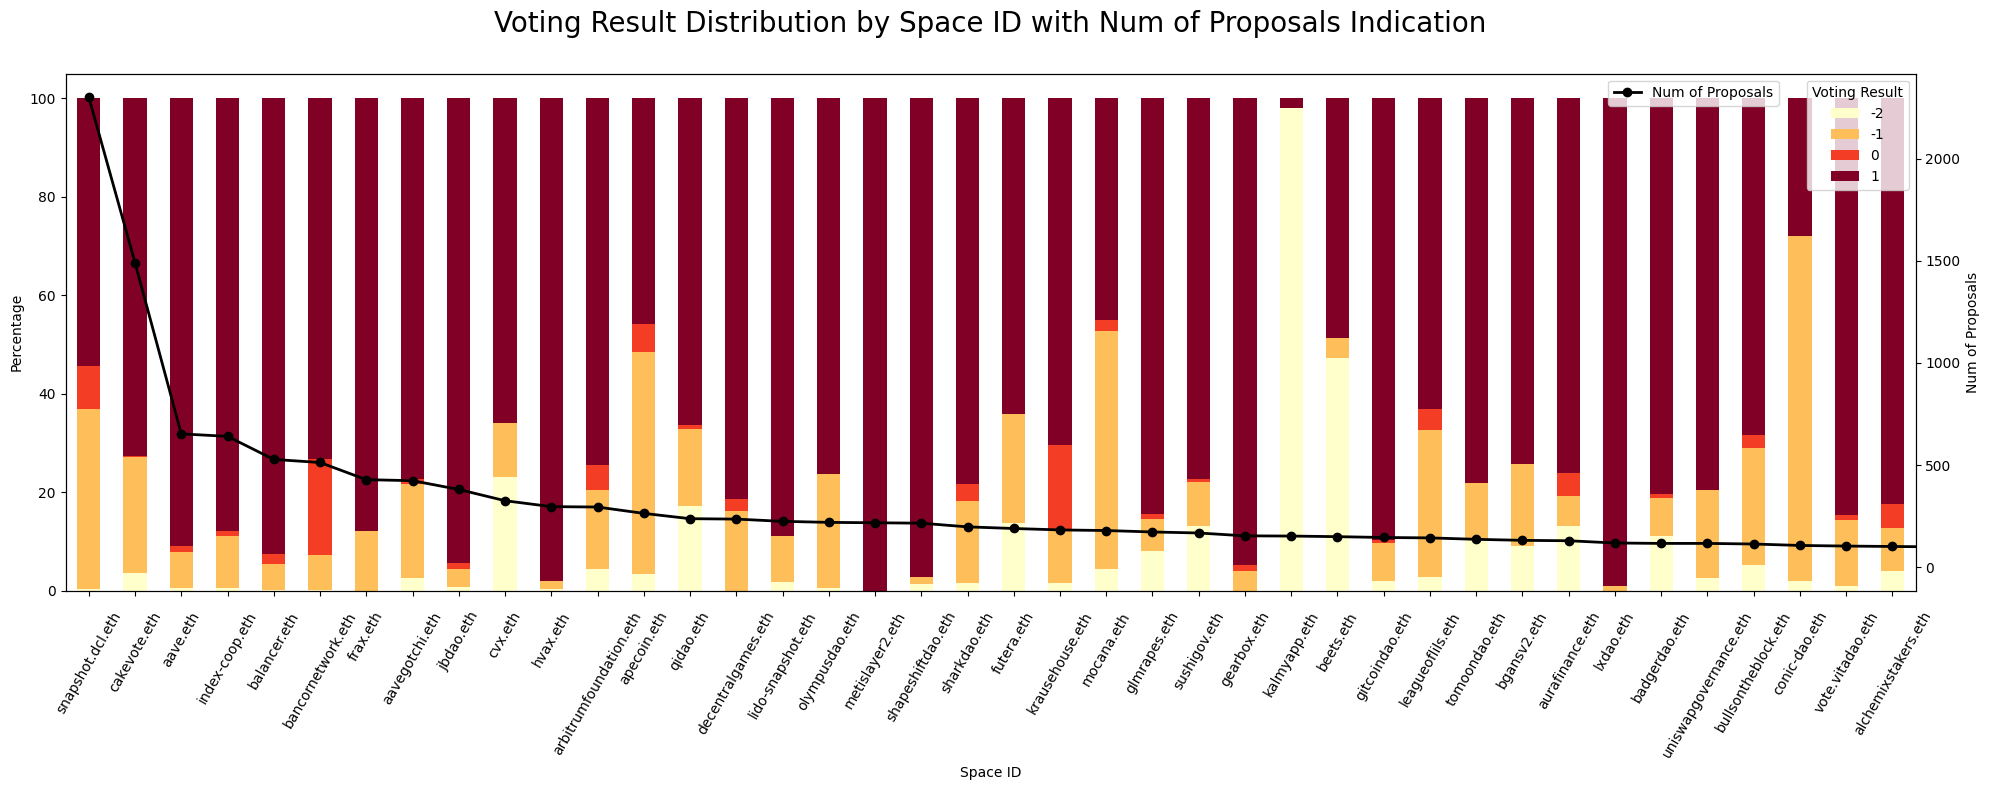

In [11]:
fig, ax1 = plt.subplots(figsize=(20, 8))

space_sentiments.iloc[:40, :-1].plot(kind='bar', stacked=True, ax=ax1, cmap='YlOrRd')
ax1.set_xlabel('Space ID')
ax1.set_ylabel('Percentage')
ax1.set_title('Voting Result Distribution by Space ID with Num of Proposals Indication', pad=30, fontsize=20)
ax1.legend(title='Voting Result', loc='upper right')
ax1.tick_params(axis='x', rotation=60, pad=10)

ax2 = ax1.twinx()
ax2.plot(space_sentiments.index, space_sentiments['total'], color='black', marker='o', linestyle='-', linewidth=2, label='Num of Proposals')
ax2.set_ylabel('Num of Proposals')
ax2.legend(loc='upper right', bbox_to_anchor=(0.93, 1), title_fontsize='medium')

plt.tight_layout()
# TODO: excel dataset

# TODO: option describe -> clean

# proposal body에 voting result 왜곡 -> 


# spread_sheet 사람별로
# 키워드 컬럼 추가 + 비고 적을 sheet 추가

plt.show()

### WordCloud

In [12]:
from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict

stopwords = set(STOPWORDS)
groups = df.groupby(['space_id', "choice_win"])
wc_gen = WordCloud(stopwords=stopwords).generate
words = { 
    idx: { 
        k: v 
        for k, v in wc_gen(' '.join(group['body_nlp'].astype(str).values)).words_.items() 
        if len(k) > 1 # 한 글자 미만 단어 삭제
    }
    for idx, group in groups
}

# defaultdict을 사용하여 키 존재 여부를 체크하지 않음
words_result = [defaultdict(float) for _ in range(4)]  
for idx, word in words.items():
    for w, p in word.items():
        words_result[idx[1]][w] += p  # 기존 값을 바로 더함

words_result = [{} for _ in range(4)]
for idx, word in words.items():
    for w, p in word.items():
        if w in words_result[idx[1]]:
            words_result[idx[1]][w] += word[w]
        else:
            words_result[idx[1]][w] = word[w]

In [ ]:
x = list(set([ k for i in range(-2, 2) for k in words_result[i].keys() ]))
words = pd.DataFrame({i: words_result[i] for i in range(-2, 2)}, index=x).fillna(0)

for i in range(-2, 2):
    for k, v in words_result[i].items():
        words.loc[k, i] = v

words.iloc[10:20]

### Clustering

In [ ]:
!pip install --user -q fastcluster

In [ ]:
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer
from scipy.stats.mstats import winsorize

words_winsorized = words.apply(lambda x: winsorize(x, limits=(0.05, 0.05)))

scaler = QuantileTransformer(output_distribution='normal')
scaled_data = scaler.fit_transform(words_winsorized)

temp = scaled_data
print(temp.shape)

sns.kdeplot(scaled_data[:, 0], label='Nothing', color='black')
sns.kdeplot(scaled_data[:, 1], label='Negative', color='red')
sns.kdeplot(scaled_data[:, 2], label='Positive', color='green')
sns.kdeplot(scaled_data[:, 3], label='Neutral', color='blue')
plt.title('Scaled Word Frequency', pad=20, fontsize=16)
plt.legend()
plt.xlabel('Standardized Value')

In [ ]:
sns.clustermap(pd.DataFrame(scaled_data, columns=words.columns, index=words.index), cmap='coolwarm', figsize=(12, 12))

plt.title('Word Frequency Clustering Heatmap', pad=20, fontsize=16)

In [ ]:
import fastcluster
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

linkage_matrix = fastcluster.linkage(scaled_data, method='ward')

plt.figure(figsize=(20, 6))

dendrogram  = sch.dendrogram(linkage_matrix)
ticks = plt.gca().get_xticks()
labels = plt.gca().get_xticklabels()

n = 100 
plt.xticks(ticks[::n], labels[::n], rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
len(set(dendrogram["color_list"])), len(dendrogram["color_list"]), words.shape

In [ ]:
word["cluster"] = [dendrogram["color_list"][0]] + dendrogram["color_list"]